# Task 1.2 DataPreparation

In [138]:
import math
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sn
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler

In [139]:
# We load the updated datasets
df_incidents = pd.read_csv('datasets_clean/incidents_clean.csv', sep=',', index_col=0)
df_poverty = pd.read_csv('datasets_clean/poverty_clean.csv', sep=',', index_col=0)
df_elections = pd.read_csv('datasets_clean/elections_clean.csv', sep=',', index_col=0)

# Datasets

In [140]:
df_incidents.head()

,date,state,city_or_county,address,latitude,longitude,congressional_district,avg_age_participants,n_participants_child,n_participants_teen,n_participants_adult,n_males,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,incident_characteristics1
0,2015-05-02,Indiana,Indianapolis,Lafayette Road and Pike Plaza,39.8322,-86.2492,7.0,19.0,0.0,0.0,1.0,1.0,0.0,0,1,0.0,0.0,1.0,Shot - Wounded/Injured
1,2017-04-03,Pennsylvania,Kane,5647 US 6,41.6645,-78.7856,5.0,62.0,0.0,0.0,1.0,1.0,0.0,1,0,0.0,0.0,1.0,"Shot - Dead (murder, accidental, suicide)"
3,2016-10-15,District of Columbia,Washington,"1000 block of Bladensburg Road, NE",38.9030,-76.9820,1.0,26.0,0.0,0.0,1.0,1.0,0.0,0,1,0.0,0.0,2.0,Shot - Wounded/Injured
4,NaN,Pennsylvania,Pittsburgh,California and Marshall Avenues,40.4621,-80.0308,14.0,40.0,0.0,0.0,1.0,1.0,0.0,0,1,0.0,1.0,2.0,Shot - Wounded/Injured
5,2014-01-18,North Carolina,Wayne County,4700 block of U.S. Highway 70 East,35.1847,-77.9527,13.0,65.0,0.0,0.0,1.0,1.0,0.0,0,1,0.0,0.0,1.0,Shot - Wounded/Injured


In [141]:
df_poverty.head()

,state,year,povertyPercentage
0,United States,2020,11.5
1,Alabama,2020,14.8
2,Alaska,2020,11.5
3,Arizona,2020,12.1
4,Arkansas,2020,15.8


In [142]:
df_elections.head()

,year,state,congressional_district,party,candidatevotes,totalvotes
0,1976,ALABAMA,1,REPUBLICAN,98257.0,157170.0
1,1976,ALABAMA,2,REPUBLICAN,90069.0,156362.0
2,1976,ALABAMA,3,DEMOCRAT,106935.0,108048.0
3,1976,ALABAMA,4,DEMOCRAT,141490.0,176022.0
4,1976,ALABAMA,5,DEMOCRAT,113553.0,113560.0


# Definition of new indicators

## Severity of the incident
We start considering the ratio of killed, injured, and unharmed participants in the incidents with respect to the total number of participants. Subsequently, we define the _severity_ of the incidents as the weighted mean of the ratios just defined. We assign to `ratio_killed` the weight 0.5, to `ratio_injured` weight 0.3 and to `ratio_unharmed` weight 0.2.

In [143]:
total = df_incidents['n_killed'] + df_incidents['n_injured'] + df_incidents['n_unharmed']
df_incidents['ratio_killed'] = df_incidents['n_killed']/total*100
df_incidents['ratio_injured'] = df_incidents['n_injured']/total*100
df_incidents['ratio_unharmed'] = df_incidents['n_unharmed']/total*100

In [144]:
df_incidents['severity'] = 0.6*df_incidents['ratio_killed'] + 0.3*df_incidents['ratio_injured'] + 0.1*df_incidents['ratio_unharmed']

In [145]:
df_incidents['severity'].describe()

count    162068.000000
mean         32.464753
std          17.181981
min          10.000000
25%          20.000000
50%          30.000000
75%          45.000000
max          60.000000
Name: severity, dtype: float64

(array([29892.,  4927., 16490.,  1846., 59351.,  7394.,   325.,  5299.,
          113., 36431.]),
 array([10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60.]),
 <BarContainer object of 10 artists>)

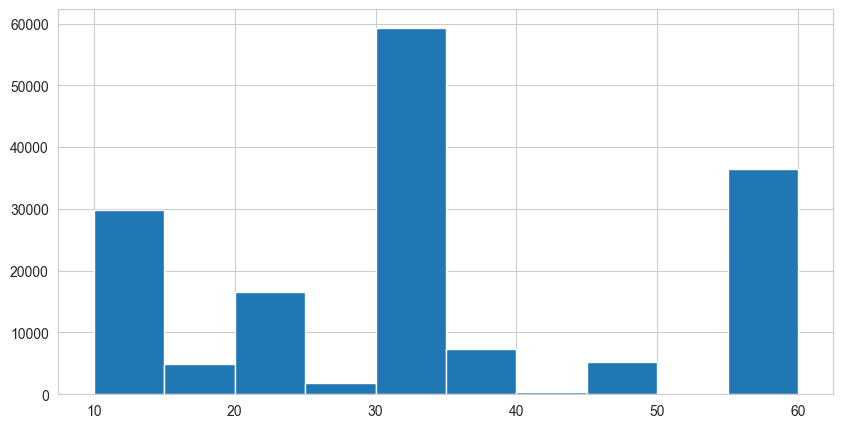

In [146]:
plt.figure(figsize=(10, 5))
plt.hist(df_incidents['severity'], bins=10)

In [147]:
# We drop the columns of the ratios
df_incidents.drop(['ratio_killed', 'ratio_injured', 'ratio_unharmed'], axis=1)

,date,state,city_or_county,address,latitude,longitude,congressional_district,avg_age_participants,n_participants_child,n_participants_teen,n_participants_adult,n_males,n_females,n_killed,n_injured,n_arrested,n_unharmed,n_participants,incident_characteristics1,severity
0,2015-05-02,Indiana,Indianapolis,Lafayette Road and Pike Plaza,39.8322,-86.2492,7.0,19.0,0.0,0.0,1.0,1.0,0.0,0,1,0.0,0.0,1.0,Shot - Wounded/Injured,30.0
1,2017-04-03,Pennsylvania,Kane,5647 US 6,41.6645,-78.7856,5.0,62.0,0.0,0.0,1.0,1.0,0.0,1,0,0.0,0.0,1.0,"Shot - Dead (murder, accidental, suicide)",60.0
3,2016-10-15,District of Columbia,Washington,"1000 block of Bladensburg Road, NE",38.9030,-76.9820,1.0,26.0,0.0,0.0,1.0,1.0,0.0,0,1,0.0,0.0,2.0,Shot - Wounded/Injured,30.0
4,NaN,Pennsylvania,Pittsburgh,California and Marshall Avenues,40.4621,-80.0308,14.0,40.0,0.0,0.0,1.0,1.0,0.0,0,1,0.0,1.0,2.0,Shot - Wounded/Injured,20.0
5,2014-01-18,North Carolina,Wayne County,4700 block of U.S. Highway 70 East,35.1847,-77.9527,13.0,65.0,0.0,0.0,1.0,1.0,0.0,0,1,0.0,0.0,1.0,Shot - Wounded/Injured,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239307,2016-01-11,Tennessee,Murfreesboro,Hazelwood Street,35.8624,-86.3695,4.0,23.0,0.0,0.0,1.0,1.0,0.0,0,1,0.0,0.0,1.0,Shot - Wounded/Injured,30.0
239308,NaN,New York,Troy,Pawling and Plum Avenues,42.7043,-73.6590,20.0,88.0,0.0,0.0,2.0,2.0,0.0,0,0,0.0,3.0,3.0,Armed robbery with injury/death and/or evidenc...,10.0
239309,2017-08-17,Tennessee,Memphis,Barron Ave and Pendleton St,35.1007,-89.9700,9.0,58.0,0.0,0.0,1.0,1.0,0.0,0,1,0.0,0.0,1.0,Shot - Wounded/Injured,30.0
239310,2016-06-07,Colorado,Colorado Springs,601 Prospect Lake Drive,38.8251,-104.8020,5.0,68.0,0.0,0.0,1.0,2.0,0.0,0,0,1.0,1.0,2.0,Non-Shooting Incident,10.0


## Injured and killed in a given place and time
We investigate how many injured and killed people have been involved w.r.t the total injured and
killed people in the same congressional district in a month

In [148]:
df_incidents.date=pd.to_datetime(df_incidents.date)

In [149]:
#- raggruppare in base al mese, congressional district, stato
#- injured / tot. injured , killed / tot. killed in congr. and month

df_incidents['year_month'] = df_incidents.date.dt.strftime('%y-%m')
df_incidents.year_month.isnull().sum()

tot_killed = df_incidents.groupby(['state', 'congressional_district', 'year_month'])['n_killed'].sum()
# Convert the Series to a DataFrame and reset the index
tot_killed_df = tot_killed.reset_index()

# Rename the 'n_killed' column to a desired name
tot_killed_df = tot_killed_df.rename(columns={'n_killed': 'total_killed'})

# Print the resulting DataFrame
print(tot_killed_df)


#Same for the injured
tot_injured = df_incidents.groupby(['state', 'congressional_district', 'year_month'])['n_injured'].sum()
# Convert the Series to a DataFrame and reset the index
tot_injured_df = tot_injured.reset_index()

# Rename the 'n_killed' column to a desired name
tot_injured_df = tot_injured_df.rename(columns={'n_injured': 'total_injured'})

         state  congressional_district year_month  total_killed
0      Alabama                     1.0      14-01             3
1      Alabama                     1.0      14-02             5
2      Alabama                     1.0      14-03             3
3      Alabama                     1.0      14-04             3
4      Alabama                     1.0      14-05             7
...        ...                     ...        ...           ...
21112  Wyoming                     1.0      17-05             0
21113  Wyoming                     1.0      17-06             0
21114  Wyoming                     1.0      17-07             0
21115  Wyoming                     1.0      17-08             3
21116  Wyoming                     1.0      17-09             1

[21117 rows x 4 columns]


In [150]:
# TODO: We recall that in the elections dataset, for the states that have just one congressional district, the number of the district was 0. We replace the zeros with 1

In [151]:
# We join the 'total_killed' and 'total_injured' columns to the incidents dataset
df_incidents =pd.merge( df_incidents, tot_killed_df, on=['state', 'congressional_district', 'year_month'])

In [152]:
df_incidents = pd.merge(df_incidents, tot_injured_df, on=['state', 'congressional_district', 'year_month'])
df_incidents.head()

,date,state,city_or_county,address,latitude,longitude,congressional_district,avg_age_participants,n_participants_child,n_participants_teen,...,n_unharmed,n_participants,incident_characteristics1,ratio_killed,ratio_injured,ratio_unharmed,severity,year_month,total_killed,total_injured
0,2015-05-02,Indiana,Indianapolis,Lafayette Road and Pike Plaza,39.8322,-86.2492,7.0,19.0,0.0,0.0,...,0.0,1.0,Shot - Wounded/Injured,0.0,100.0,0.0,30.0,15-05,3,4
1,2015-05-03,Indiana,Indianapolis,502 N. Rural Street,39.7745,-86.1166,7.0,32.0,0.0,0.0,...,0.0,2.0,"Shot - Dead (murder, accidental, suicide)",100.0,0.0,0.0,60.0,15-05,3,4
2,2015-05-25,Indiana,Indianapolis,800 block of Chapelwood Boulevard,39.7759,-86.2940,7.0,36.0,0.0,0.0,...,0.0,2.0,"Shot - Dead (murder, accidental, suicide)",100.0,0.0,0.0,60.0,15-05,3,4
3,2015-05-03,Indiana,Indianapolis,East 25th Street and North Post Road,39.8040,-86.0095,7.0,18.0,0.0,0.0,...,0.0,1.0,"Shot - Dead (murder, accidental, suicide)",100.0,0.0,0.0,60.0,15-05,3,4
4,2015-05-30,Indiana,Indianapolis,3018 West 16th Street,39.7882,-86.2091,7.0,53.0,0.0,0.0,...,0.0,1.0,Shot - Wounded/Injured,0.0,100.0,0.0,30.0,15-05,3,4


In [153]:
# We distinguish between the case with total_killed = 0, and total_killed != 0

def f(x, y):
    if y!=0:
        return x/y
    else:
        return 0
df_incidents['killed_by_district'] = df_incidents.apply(lambda row: f(row['n_killed'], row['total_killed']), axis=1)

df_incidents['injured_by_district'] = df_incidents.apply(lambda row: f(row['n_injured'], row['total_injured']), axis=1)

# Aggregated dataset

We group the incidents that happened in the same congressional district of each state: label [state, congressional district] (and eventually in the same year, month).

We consider the numerical features of the dataset df_incidents:
- the mean of 'avg_age_participants'
- the sum of the features 'n_participants_child'-'n_participants'

We also add the 'povertyPercentage' feature of df_poverty for each state, year.

Finally, given the year of the incident, we add the 'party', 'candidatevotes', 'totalvotes' features from the dataset df_elections for each [state, congressional district].